In [1]:
import numpy as np
import scipy.io
from pathlib import Path

In [2]:
# Load .mat files
data_path = Path('D:/MATLAB_Analysis/Pre+process/Fncs/Run_tuning/testing_model_helper_fns/whisker_position_decoding_model/github_files/raw_data')
params1 = scipy.io.loadmat(data_path / 'params.mat')
run_speed = scipy.io.loadmat(data_path / 'run_speed.mat')['run_speed']
SpikeTimes = scipy.io.loadmat(data_path / 'SpikeTimes.mat')['SpikeTimes']
trial_times = scipy.io.loadmat(data_path / 'trial_times.mat')
whisker_position = scipy.io.loadmat(data_path / 'whisker_position.mat')['whisker_position']
endT = trial_times['endT'];
startT = trial_times['startT'];
params = params1['params']
recording_endtime = params['recording_endtime'][0,0]
recording_fps = params['recording_fps'][0,0]
features = params['features'][0, 0]  #'features' is a field in actual_params
fps = features['fps'][0, 0]  # 'fps' is a field in features
vid_start_time = features['VidStartTime'][0, 0]  
vid_end_time = features['VidEndTime'][0, 0]
spike_params = params['spike'][0, 0]
Neuron_ID = spike_params['Neuron_ID'][0, 0]


In [3]:
# get bins
bin_res = 0.015
bins = np.arange(0, recording_endtime, bin_res)
# number of spike bins of size bin_res to used for decoding single feature bins
nBins = 11  # has to be an odd number 
VidStartTime = np.array([time[0] for time in vid_start_time])
VidEndTime = np.array([time[0] for time in vid_end_time])

In [4]:
# bin feature and neuron data
from functions import *
whisker_binned = get_features_in_timebins(bins, whisker_position, fps, VidStartTime, VidEndTime)
speed_binned = get_features_in_timebins(bins, run_speed, fps, VidStartTime, VidEndTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [10]:
# bin spike data
spike = np.array([np.histogram(SpikeTimes[n][0], bins)[0] / bin_res for n in range(Neuron_ID.shape[0])])

In [11]:
# Select data between startT & endT
startT = trial_times['startT']
endT = trial_times['endT']
BOOL = [np.any((bin_value > startT) & (bin_value < endT)) for bin_value in bins]

In [12]:
# select neurons
all_units = np.arange(Neuron_ID.shape[0])
spike_select = spike[all_units, :]

In [9]:
# Decoding whisker position
# generate design matrix
X, output_whisker, trial_start_idx, trial_end_idx = get_design_matrix(spike_select, whisker_binned, BOOL, nBins-1)
#find_alpha_ridge_regression(X,output_whisker)
testdata_whisker,preddata_whisker = perform_decoding(X, output_whisker, 2700)
r2 = get_errors(testdata_whisker,preddata_whisker)

Mean Squared Error (Cross-Validation): 43.64602599566098
Mean Squared Error (Test Set): 40.926172229744935
Rsquare: 0.7630790372528163
SSE: 85904.03551023462
SST: 362585.2035807489
R^2: 0.7630790372528163
MSE: 40.926172229744935
MAE: 5.038689160710766
RMSE: 6.397356659570024


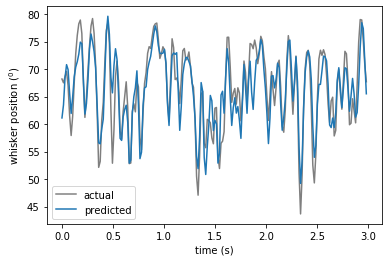

In [33]:
# PLor example trial
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# select 2 seconds of data
t_sec = 3
ii = np.random.randint(len(testdata_whisker)-t_sec*1/bin_res)
stop_idx = int(ii+t_sec*(1/bin_res))
x = np.arange(0,stop_idx-ii,1)*bin_res
# Gaussian smoothing
sigma = 1  # std of the Gaussian kernel
testdata_whisker_smooth = gaussian_filter(testdata_whisker, sigma=sigma)
preddata_whisker_smooth = gaussian_filter(preddata_whisker, sigma=sigma)

plt.plot(x, testdata_whisker_smooth[ii:stop_idx], label='actual',color = 'black', alpha=.5)
plt.plot(x, preddata_whisker_smooth[ii:stop_idx], label='predicted')

plt.xlabel('time (s)')
plt.ylabel('whisker position ($^0$)')
plt.legend()
plt.show()

In [13]:
# Decoding Locomotion speed
X, output_speed, trial_start_idx, trial_end_idx = get_design_matrix(spike_select, speed_binned, BOOL, nBins-1)
#find_alpha_ridge_regression(X,output_speed)
testdata_speed,preddata_speed = perform_decoding(X, output_speed, 1800)
r2 = get_errors(testdata_speed,preddata_speed)

Mean Squared Error (Cross-Validation): 63.915621252844815
Mean Squared Error (Test Set): 62.63956115444109
Rsquare: 0.8615736780488504
SSE: 131480.43886317185
SST: 949822.5265970085
R^2: 0.8615736780488504
MSE: 62.63956115444109
MAE: 6.310841199805321
RMSE: 7.914515850918557


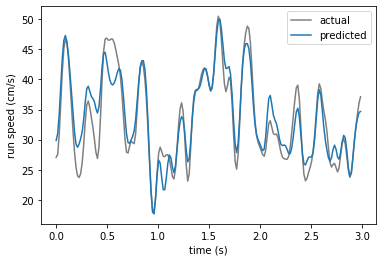

In [17]:
# PLor example trial
import matplotlib.pyplot as plt

# select 2 seconds of data
t_sec = 3
ii = np.random.randint(len(testdata_speed)-t_sec*1/bin_res)
stop_idx = int(ii+t_sec*(1/bin_res))
x = np.arange(0,stop_idx-ii,1)*bin_res

# Gaussian smoothing
sigma = 2  # Standard deviation of the Gaussian kernel
testdata_speed_smooth = gaussian_filter(testdata_speed, sigma=sigma)
preddata_speed_smooth = gaussian_filter(preddata_speed, sigma=sigma)

plt.plot(x, testdata_speed_smooth[ii:stop_idx], label='actual',color = 'black', alpha=.5)
plt.plot(x, preddata_speed_smooth[ii:stop_idx], label='predicted')

plt.xlabel('time (s)')
plt.ylabel('run speed (cm/s)')
plt.legend()
plt.show()